In [1]:
import pyodbc 
import pandas as pd
import numpy as np
import numpy as np

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE

from collections import Counter

from bokeh.plotting import show, output_file
from bokeh.plotting import figure as FIG ## this is to avoid ambiguous function names from plt and bokeh
from bokeh.tile_providers import CARTODBPOSITRON, STAMEN_TERRAIN_RETINA, CARTODBPOSITRON_RETINA
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.palettes import Spectral6
from bokeh.io import show, output_notebook, push_notebook
from bokeh.transform import linear_cmap
from bokeh.models.widgets import Panel, Tabs

from bokeh.plotting import output_file, save

from pyproj import Proj, transform

output_notebook()

Loading BokehJS ...

In [2]:
## load data

cols = ['postcode', 'woonplaats', 'provincie', 'latitude', 'longitude', 'dichtheid','pct_autoch'
                                   ,'pct_w_alloch','pct_nw_alloch','pct_uitk',
                                   'apotheeknr','apotheek','postcode','nr_records','avg_geb_jr','marge','m_marge','sd_marge',
                                   'omzet','kosten','m_clawback','sd_clawback','m_amount','sd_amount','pct_man','pct_vrouw',
                                   'zkruis','vgz','cz','menzis','prijslijst','pct_zkruis','pct_vgz','pct_cz','pct_menzis','pct_prijslijst',
                                   'pct_28','pct_2949','pct_4969','pct_69','atc_c','atc_a','atc_n','art_chol','art_pant','art_acet',
                                   'art_meto','art_metf','pct_h_opg']

#specify expected amount of rows, columns
npdf = np.zeros((788,len(cols)), dtype = object)

con = pyodbc.connect('Driver={SQL Server};'
                      'Server=PPC-325\MSSQLSERVER01;'
                      'Database=Clustering;'
                      'Trusted_Connection=yes;'
                      'UID=KK32\teun.cuijpers;')
c = con.cursor()

start, stop, mutate, status, status_val, artikel, ZIN, Id = [],[],[],[],[],[],[],[]

QUERY = """
select 
	postcode, 
	woonplaats, 
	provincie, 
	latitude, 
	longitude, 
	OAD as Dichtheid,
	P_AUTOCHT as pct_autoch,
	P_WALLOCH as pct_w_alloch,
	P_NWALLOCH as pct_nw_alloch,
	UITKMINAOW / INWONER as pct_uitk,
	a.*,
    d.Hoogopgeleiden as pct_h_opg

from ApotheekData02102018 a
inner join GeoData.dbo.Fact_GemPC4GPS b on substring(BezoekPostcode,1,4) = postcode
inner join GeoData.dbo.DimPC4_2017 c on b.postcode = c.PC4
left join GeoData.dbo.DimHoogopgeleid d on b.gemeente = d.Gemeente
"""

c.execute(QUERY)

## stuff data into np array because pd doesn't like the dtype
for idx, i in enumerate(c):
    npdf[idx] = i

con.commit()

c.close()

print('query worked!')

df = pd.DataFrame(npdf, columns = cols)

##create df with only numeric vars
## and remove double vars (e.g. insurance comps) and redundant vars (e.g. location, birth year)
## also remove hoogopgeleiden; many missing values
## vars removed because they don't correlate to anything; ['pct_nw_alloch','sd_marge','sd_clawback','pct_prijslijst',,'sd_amount']
## 'kosten' removed because identical to 'omzet'
df2 = df[['dichtheid','pct_autoch','pct_w_alloch','pct_nw_alloch','pct_uitk',
                                   'nr_records','marge','m_marge',
                                   'omzet','m_clawback','m_amount','pct_man','pct_vrouw',
                                   'pct_zkruis','pct_vgz','pct_cz','pct_menzis',
                                   'pct_28','pct_2949','pct_4969','pct_69','atc_c','atc_a','atc_n','art_chol','art_pant','art_acet',
                                   'art_meto','art_metf']]

##string to int
df2 = df2.apply(pd.to_numeric)
##replace all negative numbers to -1
df2[df2 < 0] = -1
##set those tot nan
df2 = df2.replace({-1: np.NaN})
##impute mean values
df2 = df2.fillna(df2.mean())
print(df2[:10])

## df3 containing pharmacy characteristics for map plotting
df3 = df[['postcode', 'woonplaats', 'provincie', 'latitude', 'longitude','apotheek','pct_prijslijst']]

query worked!
   dichtheid  pct_autoch  pct_w_alloch  pct_nw_alloch  pct_uitk  nr_records  \
0     6907.0        60.0          30.0           10.0  0.085537       50810   
1     6224.0        60.0          20.0           20.0  0.129032       72203   
2     6224.0        60.0          20.0           20.0  0.129032       20590   
3     2645.0        60.0          20.0           20.0  0.124031      861607   
4    10975.0        60.0          30.0           10.0  0.094193       95709   
5     2720.0        40.0          10.0           50.0  0.186344       33135   
6     2510.0        80.0          10.0           10.0  0.117899      202381   
7     2690.0        50.0          10.0           40.0  0.125574      205654   
8     8878.0        50.0          20.0           20.0  0.118897      120948   
9     9734.0        60.0          30.0           10.0  0.080349       89091   

       marge   m_marge       omzet  m_clawback    ...     pct_4969    pct_69  \
0  178639.44  3.515832  1902359.66  

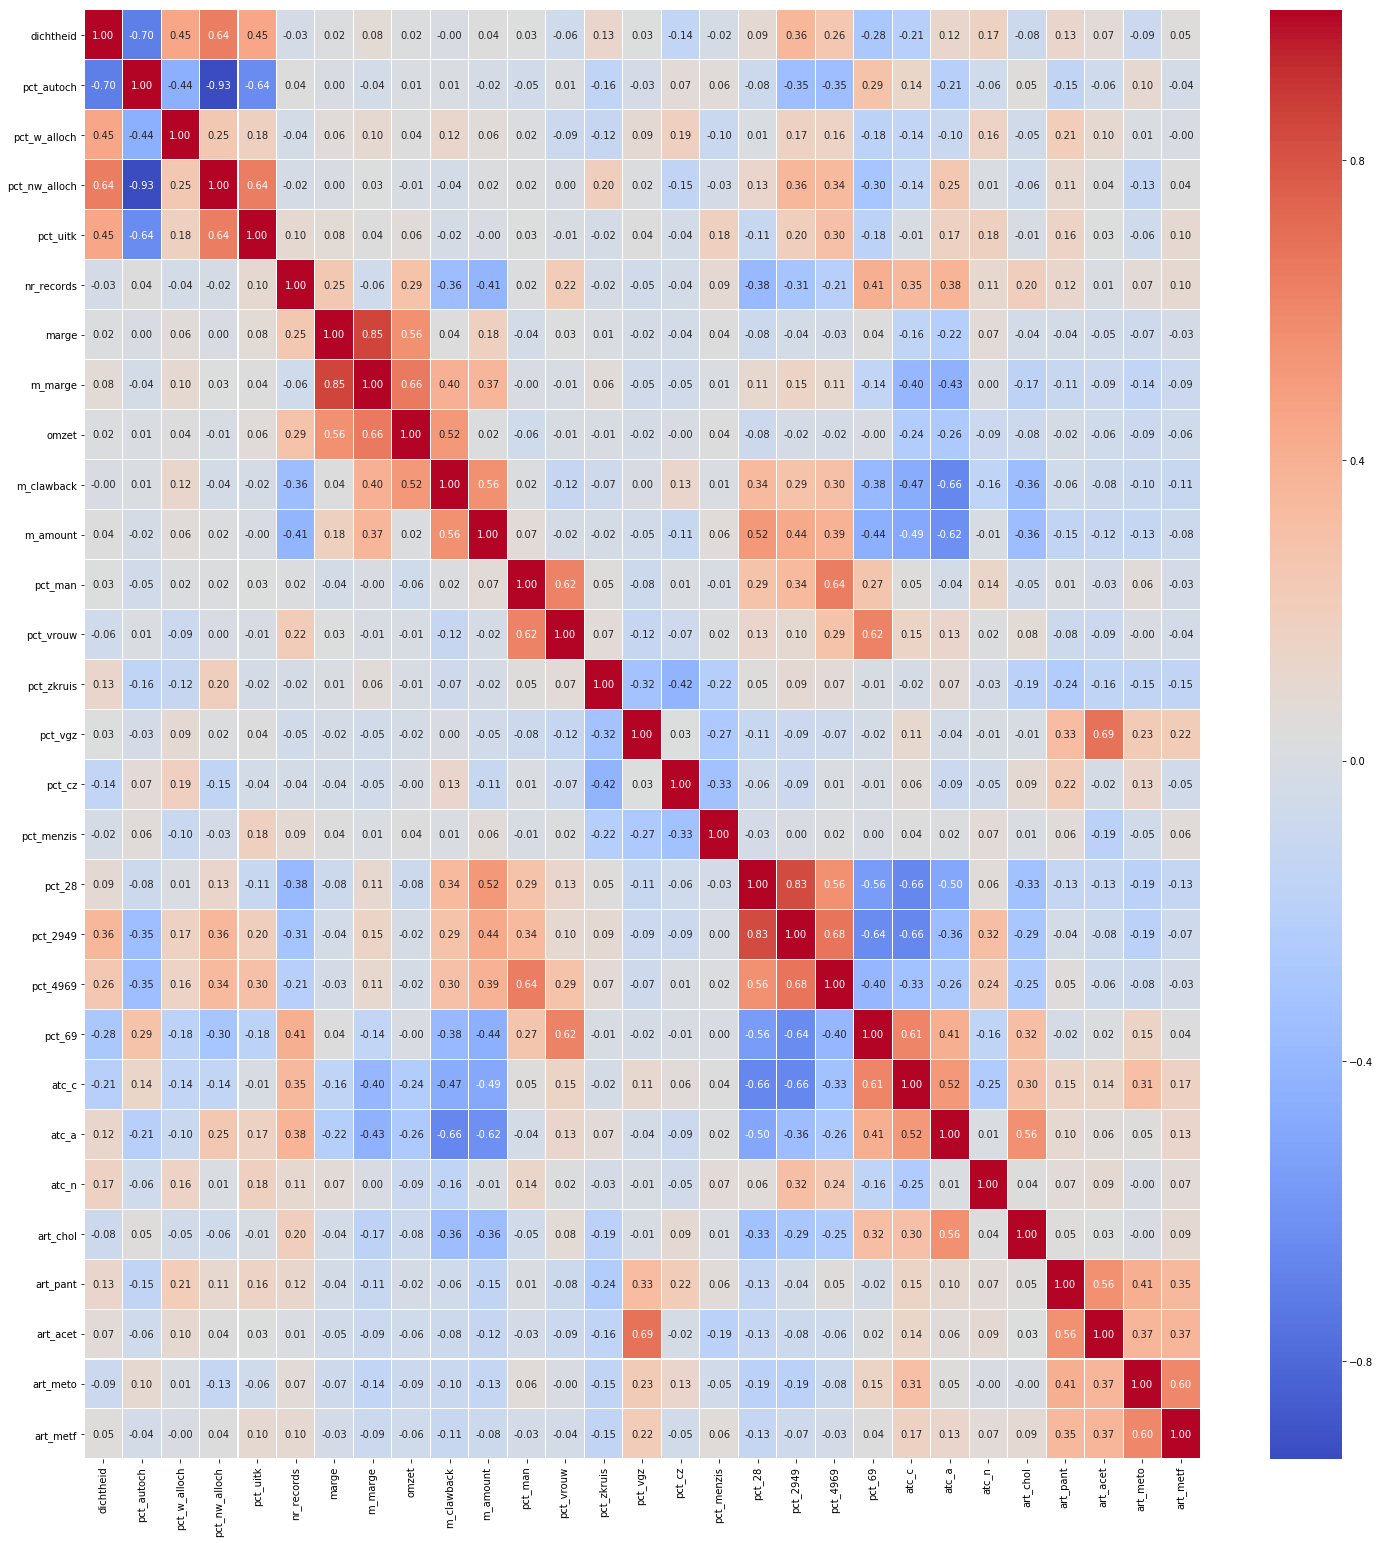

In [3]:
##some exploration; correlation heatmap
f, ax = plt.subplots(figsize=(25, 25))
corr = df2.corr(method = 'pearson')
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',linewidths=.05)
f.subplots_adjust(top=0.93)
# t= f.suptitle('Correlation Heatmap', fontsize=14)
figure = hm.get_figure()    
figure.savefig('heatmap.png')

In [4]:
# print(df2.isna().sum())

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df2) 

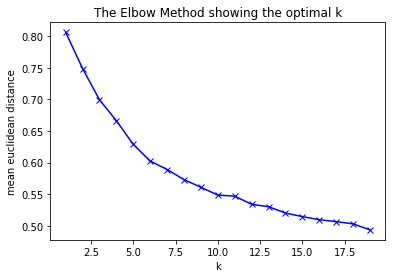

In [5]:
##evaluate kmeans with the elbow method: 
distortions = []
K = range(1,20)
for i in K: 
    km = KMeans(n_clusters=i) 
    km.fit(scaled)
    centroids = km.cluster_centers_
    labels = km.labels_
# compute for every case euclidean distance to every centroid. Select shortest distance for each case. 
# take the sum of all distances, compute mean distance. 
    distortions.append(sum(np.min(cdist(scaled, centroids, 'euclidean'), axis=1)) / scaled.shape[0])

## elbow plot
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('mean euclidean distance')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [6]:
K = 6
## apparently, diminished returns after 8 clusters, s let's set K to 8 and annotate the data
kmeans = KMeans(n_clusters=K, verbose = 0, max_iter = 1000) 
kmeans.fit(scaled)

## label the data with the model
labels = kmeans.labels_
print(Counter(labels))

## Concatenate df and labels
labels = pd.DataFrame(labels, columns = ['label'])
df2 = pd.concat([df2,labels], axis = 1)

Counter({2: 219, 0: 140, 4: 125, 1: 123, 3: 109, 5: 72})


In [7]:
cols2 = ['length','mdichtheid','m_pct_autoch','m_pct_w_alloch','m_pct_nw_alloch','m_pct_uitk',
                                   'm_nr_records','m_marge','m_m_marge',
                                   'm_omzet','m_m_clawback','m_m_amount','m_pct_man','m_pct_vrouw',
                                   'm_pct_zkruis','m_pct_vgz','m_pct_cz','m_pct_menzis',
                                   'm_pct_28','m_pct2949','m_pct_4969','m_pct69','m_atc_c','m_atc_a','m_atc_n','m_art_chol','m_art_pant','m_art_acet',
                                   'm_art_meto','m_art_metf','cluster_nr']

## aggregate data and put into pd df
aggregates = np.zeros((K,len(cols2)), dtype = object)

for i in range(K): 

    cluster = df2[df2.label == i]
    means = [j for j in cluster.mean(axis = 0)]
    total = [len(cluster)] + means
    aggregates[i] = total




aggregates = pd.DataFrame(aggregates, columns = cols2)

writer = pd.ExcelWriter('output_kmeans.xlsx')
aggregates.to_excel(writer,'Sheet1')
writer.save()

aggregates

,length,mdichtheid,m_pct_autoch,m_pct_w_alloch,m_pct_nw_alloch,m_pct_uitk,m_nr_records,m_marge,m_m_marge,m_omzet,...,m_pct69,m_atc_c,m_atc_a,m_atc_n,m_art_chol,m_art_pant,m_art_acet,m_art_meto,m_art_metf,cluster_nr
0,140,1449.61,80.1429,11.5714,7.07143,0.0920253,154258,127839,0.903801,1.50938e+06,...,0.544406,0.273323,0.194806,0.165485,0.0212614,0.0120936,0.00475151,0.00821758,0.00559936,0
1,123,1922.98,76.6667,10.5691,13.4959,0.0846362,94177.7,209589,1.72932,2.08956e+06,...,0.331495,0.183795,0.164885,0.173351,0.0100533,0.00699524,0.00497583,0.0047493,0.00409482,1
2,219,1617.2,82.4658,8.35616,8.41513,0.0822121,160865,169885,1.1136,1.56232e+06,...,0.576149,0.266236,0.198386,0.165232,0.0178762,0.00587966,0.00429509,0.00737547,0.00608872,2
3,109,1513.27,82.2936,8.80734,8.83407,0.1051,171666,190020,1.12,1.78157e+06,...,0.524373,0.265265,0.193434,0.173777,0.0178999,0.0111746,0.0041596,0.00742595,0.00733425,3
4,125,1775.36,78.4,11.04,10.56,0.0926514,149889,134904,0.927482,1.48317e+06,...,0.529547,0.275713,0.192161,0.169234,0.0174815,0.0145894,0.0158354,0.0104063,0.00887228,4
5,72,5059.86,37.9167,14.0278,47.2222,0.153753,133804,166820,1.38314,1.70064e+06,...,0.398587,0.239738,0.208245,0.16727,0.0138703,0.0121388,0.006514,0.00553197,0.00579843,5


<IPython.core.display.Javascript object>


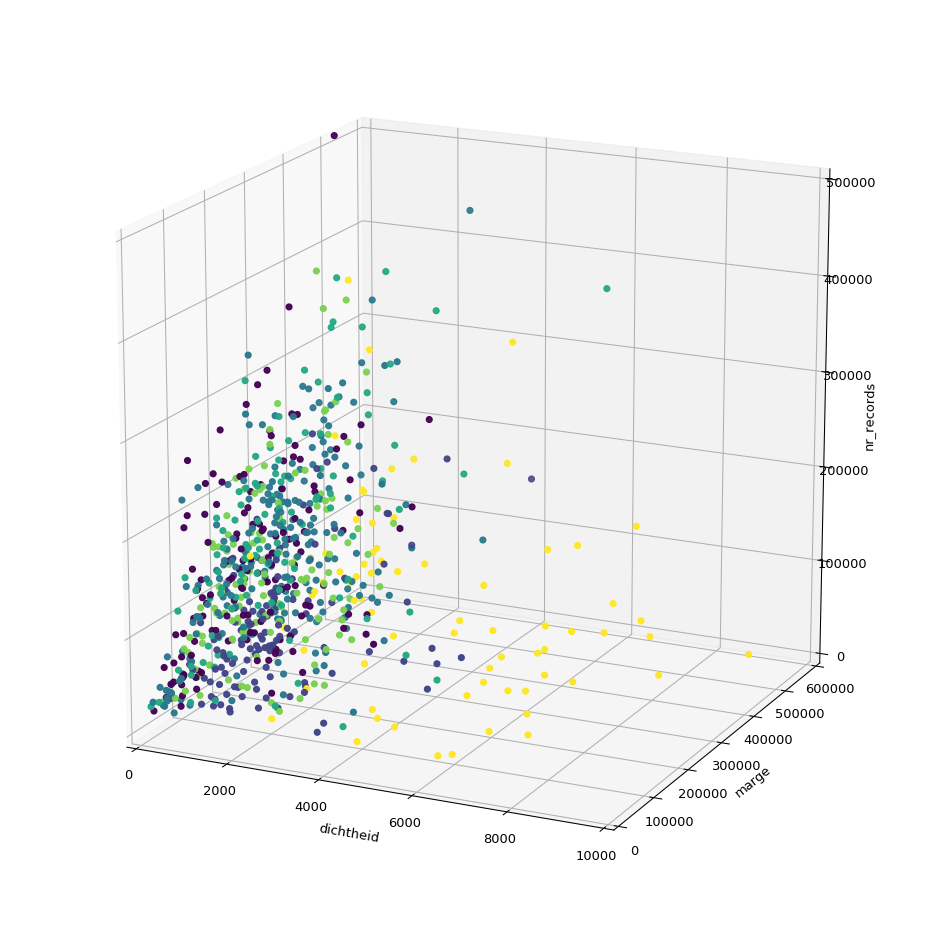

In [16]:
##visualization of important variables
%matplotlib notebook

fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)

ax.scatter(df2['dichtheid'], df2['marge'], df2['nr_records'], c = df2['label'])

ax.set_xlabel('dichtheid')
ax.set_ylabel('marge')
ax.set_zlabel('nr_records')

ax.set_xlim(0,10000)
ax.set_ylim(0,600000)
ax.set_zlim(0,500000)

plt.show()



<IPython.core.display.Javascript object>


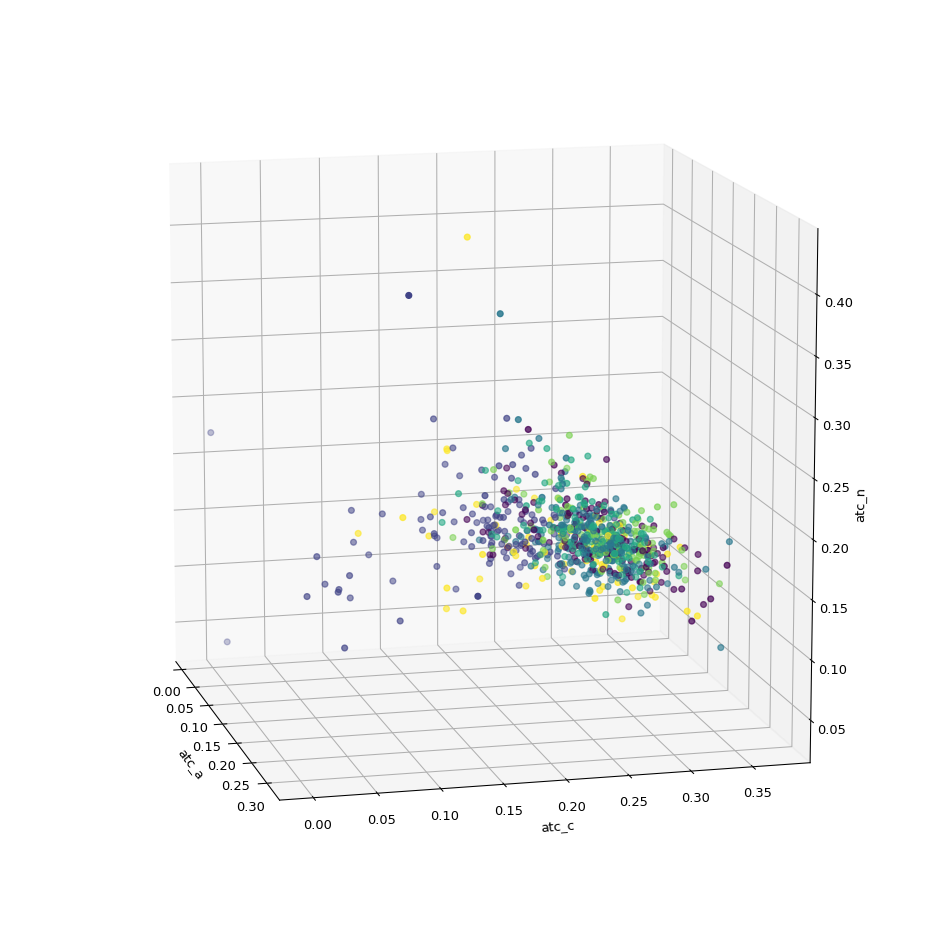

In [17]:
##visualization of important variables
%matplotlib notebook

fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)

v1 = 'atc_a'
v2 = 'atc_c'
v3 = 'atc_n'

ax.scatter(df2[v1], df2[v2], df2[v3], c = df2['label'])

ax.set_xlabel(v1)
ax.set_ylabel(v2)
ax.set_zlabel(v3)

# ax.set_xlim(0,10000)
# ax.set_ylim(0,600000)
# ax.set_zlim(0,500000)

plt.show()

<IPython.core.display.Javascript object>


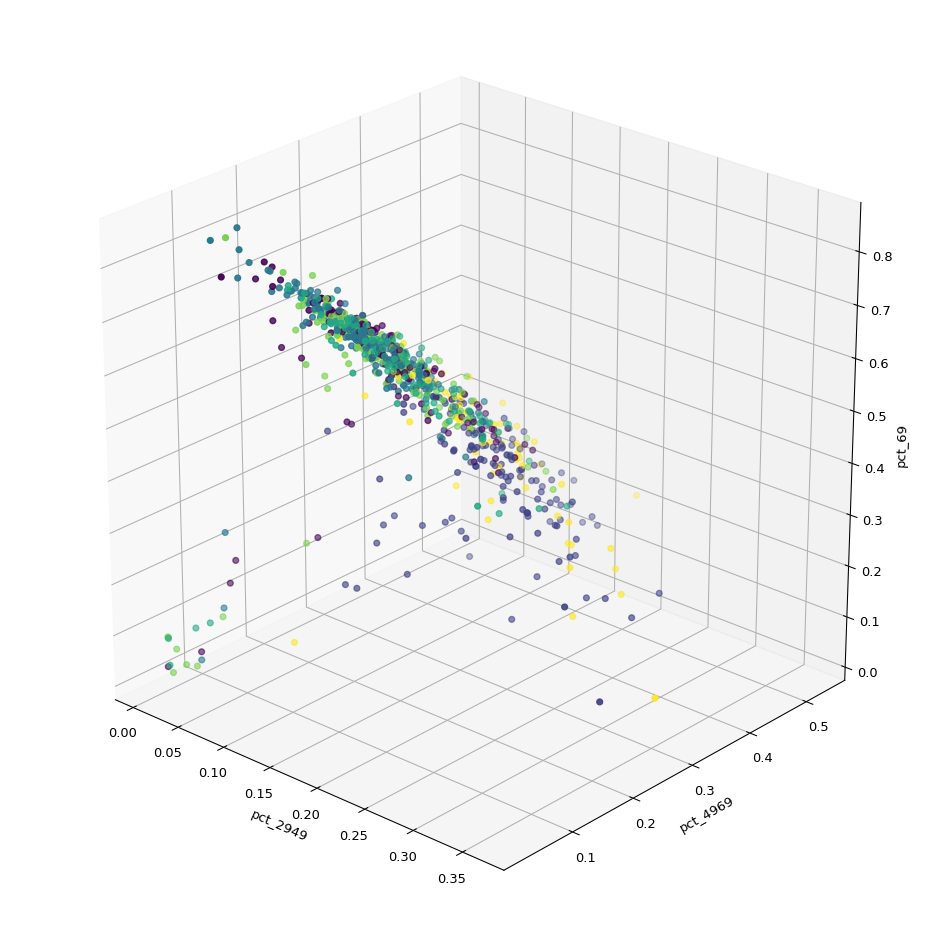

In [18]:
##visualization of important variables
%matplotlib notebook

fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)

v1 = 'pct_2949'
v2 = 'pct_4969'
v3 = 'pct_69'

ax.scatter(df2[v1], df2[v2], df2[v3], c = df2['label'])

ax.set_xlabel(v1)
ax.set_ylabel(v2)
ax.set_zlabel(v3)

# ax.set_xlim(0,10000)
# ax.set_ylim(0,600000)
# ax.set_zlim(0,500000)

plt.show()

In [11]:
## create coordinate df

lat, long = df3['latitude'], df3['longitude']

lat_trans, long_trans = [],[]
for idx, i in enumerate(long) :
    tr = transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), long[idx], lat[idx])
    long_trans.append(tr[0])
    lat_trans.append(tr[1])

coordinates = pd.DataFrame({'long_t': long_trans,'lat_t':lat_trans})

## merge sets

merged = pd.concat([df2,df3,coordinates], axis = 1)
merged


,dichtheid,pct_autoch,pct_w_alloch,pct_nw_alloch,pct_uitk,nr_records,marge,m_marge,omzet,m_clawback,...,postcode,postcode,woonplaats,provincie,latitude,longitude,apotheek,pct_prijslijst,long_t,lat_t
0,6907.0,60.0,30.0,10.0,0.085537,50810,178639.44,3.515832,1902359.66,0.523750,...,1011,1011 RB,Amsterdam,Noord-Holland,52.373,4.90396,De Castro Apotheek,0.007518,545905.940452,6.867847e+06
1,6224.0,60.0,20.0,20.0,0.129032,72203,167545.65,2.320480,1650678.51,0.414169,...,1013,1013 KH,Amsterdam,Noord-Holland,52.3968,4.87661,Service Apotheek Mouw & Kruijsse,0.004625,542861.374643,6.872190e+06
2,6224.0,60.0,20.0,20.0,0.129032,20590,27988.02,1.359301,381439.59,0.560786,...,1013,1013 CR,Amsterdam,Noord-Holland,52.3968,4.87661,Service Apotheek Amsterdam,0.005585,542861.374643,6.872190e+06
3,2645.0,60.0,20.0,20.0,0.124031,861607,260895.48,0.302801,2458882.58,0.026791,...,1014,1014 BJ,Amsterdam,Noord-Holland,52.3923,4.85588,Farmadam apotheek,0.683026,540554.556495,6.871372e+06
4,10975.0,60.0,30.0,10.0,0.094193,95709,266937.62,2.789054,2532064.80,0.445030,...,1015,1015 MR,Amsterdam,Noord-Holland,52.3791,4.88511,Jordaan Service Apotheek,0.003228,543807.846350,6.868963e+06
5,2720.0,40.0,10.0,50.0,0.186344,33135,19226.63,0.580251,289961.11,0.294284,...,1021,1021 NT,Amsterdam,Noord-Holland,52.3843,4.92092,Apotheek Ardalan,0.006337,547794.286371,6.869908e+06
6,2510.0,80.0,10.0,10.0,0.117899,202381,244838.31,1.209789,1861022.82,0.244524,...,1023,1023BC,Amsterdam,Noord-Holland,52.3871,4.94969,Nieuwendammer Apotheek,0.001734,550996.469447,6.870419e+06
7,2690.0,50.0,10.0,40.0,0.125574,205654,264592.69,1.286591,2446087.44,0.301956,...,1025,1025 EX,Amsterdam,Noord-Holland,52.3996,4.93696,Noordam Service apotheek,0.001006,549579.806475,6.872707e+06
8,8878.0,50.0,20.0,20.0,0.118897,120948,242725.71,2.006860,1944289.96,0.339374,...,1051,1051HL,Amsterdam,Noord-Holland,52.3798,4.86862,Service Apotheek Staatslieden,0.001728,541972.688884,6.869087e+06
9,9734.0,60.0,30.0,10.0,0.080349,89091,176762.50,1.984066,1984601.00,0.363860,...,1054,1054 JS,Amsterdam,Noord-Holland,52.3612,4.86536,Staring Apotheek,0.047995,541609.253011,6.865706e+06


In [12]:
## bokeh definition
def CreatePanel(df, colorvar, title, sizevar = None): 
    
    ##if there is a sizevar, standardize to range 5 to 15
    if sizevar != None: 
        
        size = []
        for i in df[sizevar]:
            size.append(i / np.max(df[sizevar]) * 10 + 5)
        
        df2 = pd.DataFrame({'size' : size})
        
        df3 = pd.merge(df[['long_t', 'lat_t', colorvar, sizevar,'apotheek', 'woonplaats']], df2, left_index=True, right_index=True)

        mapper = linear_cmap(field_name=colorvar, palette=Spectral6 ,low=np.min(df[colorvar]),high=np.max(df[colorvar]))
        source = ColumnDataSource(df3)
        # range bounds supplied in web mercator coordinates
        p = FIG(title = 'Apotheken in Nederland, met ' + title + ' per apotheek',
                   plot_width = 900, plot_height = 950,
                   x_axis_type="mercator", y_axis_type="mercator")
        p.add_tile(CARTODBPOSITRON_RETINA)
        p.circle('long_t', 'lat_t', size = 'size', source=source, color= mapper, line_color=mapper)
    
    ##else, define plot with size = 10
    else: 
        mapper = linear_cmap(field_name=colorvar, palette=Spectral6 ,low=np.min(df[colorvar]),high=np.max(df[colorvar]))
        source = ColumnDataSource(df[['long_t', 'lat_t', colorvar,'apotheek', 'woonplaats']])
        # range bounds supplied in web mercator coordinates
        p = FIG(title = 'Apotheken in Nederland, met ' + title + ' per apotheek',
                   plot_width = 900, plot_height = 950,
                   x_axis_type="mercator", y_axis_type="mercator")
        p.add_tile(CARTODBPOSITRON_RETINA)
        p.circle('long_t', 'lat_t', size = 10, source=source, color= mapper, line_color=mapper)
    
    
    hover = HoverTool(tooltips = [('Apotheek:', '@apotheek'), 
                                  ('Gemeente:', '@woonplaats'),
                                  (title + ':', '@' + colorvar)
                                  ])
    p.add_tools(hover)
    tab = Panel(child=p, title=title)
    return tab

In [13]:
tab1 = CreatePanel(merged, 'label', 'clustering label')

tabs = Tabs(tabs=[tab1])

show(tabs)

In [14]:
tab2 = CreatePanel(merged, 'pct_zkruis', 'proportie declaraties ZK')
tab3 = CreatePanel(merged, 'pct_vgz', 'proportie declaraties VGZ')
tab4 = CreatePanel(merged, 'pct_cz', 'proportie declaraties CZ')
tab5 = CreatePanel(merged, 'pct_menzis', 'proportie declaraties Menzis')
tab6 = CreatePanel(merged, 'pct_prijslijst', 'percentage declaraties prijslijst')

tabs = Tabs(tabs=[tab2,tab3,tab4,tab5,tab6])

# output_file("test.html")
# save(tabs)
show(tabs)

In [15]:
tab7 = CreatePanel(merged, 'nr_records', 'nr_records')
tab8 = CreatePanel(merged, 'marge', 'marge')

tabs = Tabs(tabs=[tab7,tab8])

show(tabs)